In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [ ]:
# Hyperparameters
batch_size = 64
latent_dim = 100
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# DataLoader for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 103344530.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40231050.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23856456.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17721422.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
d_loss_list = []
g_loss_list = []

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.view(-1, 784).to(device)
        batch_size = real_images.size(0)  # Get the actual batch size
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss_list.append(d_loss)
        d_loss.backward()
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss_list.append(g_loss)
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save generated images
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        generated_images = generator(z).view(-1, 1, 28, 28)
        save_image(generated_images, f'gan_generated_epoch_{epoch+1}.png', nrow=4, normalize=True)

Epoch [0/50], Step [0/938], D Loss: 1.0334, G Loss: 0.7967
Epoch [0/50], Step [100/938], D Loss: 1.3792, G Loss: 1.9049
Epoch [0/50], Step [200/938], D Loss: 1.1831, G Loss: 1.4453
Epoch [0/50], Step [300/938], D Loss: 1.0323, G Loss: 1.9142
Epoch [0/50], Step [400/938], D Loss: 0.9631, G Loss: 1.3240
Epoch [0/50], Step [500/938], D Loss: 1.0943, G Loss: 2.2314
Epoch [0/50], Step [600/938], D Loss: 0.9723, G Loss: 1.5097
Epoch [0/50], Step [700/938], D Loss: 1.4470, G Loss: 0.5552
Epoch [0/50], Step [800/938], D Loss: 0.8847, G Loss: 1.4140
Epoch [0/50], Step [900/938], D Loss: 1.0001, G Loss: 1.2133
Epoch [1/50], Step [0/938], D Loss: 1.0041, G Loss: 0.9913
Epoch [1/50], Step [100/938], D Loss: 0.9089, G Loss: 1.2627
Epoch [1/50], Step [200/938], D Loss: 0.9020, G Loss: 1.4390
Epoch [1/50], Step [300/938], D Loss: 1.1421, G Loss: 0.6499
Epoch [1/50], Step [400/938], D Loss: 1.2845, G Loss: 1.9323
Epoch [1/50], Step [500/938], D Loss: 0.9643, G Loss: 1.2245
Epoch [1/50], Step [600/938]

In [ ]:
import glob
import matplotlib.pyplot as plt
import cv2

<ipython-input-14-e85b45a4ccda>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


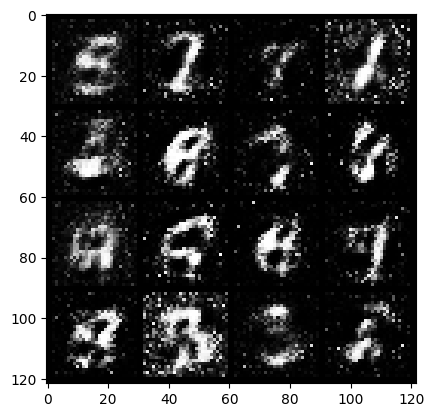

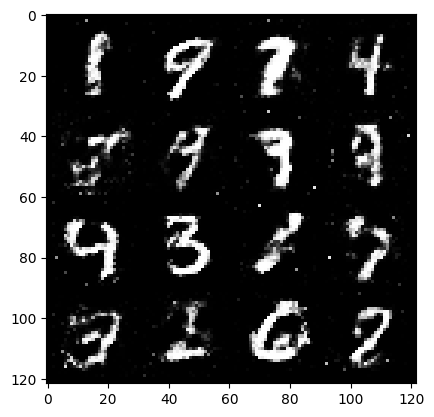

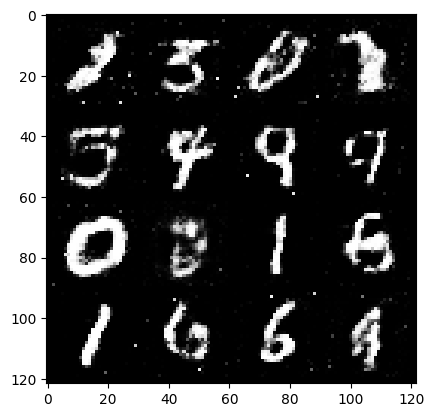

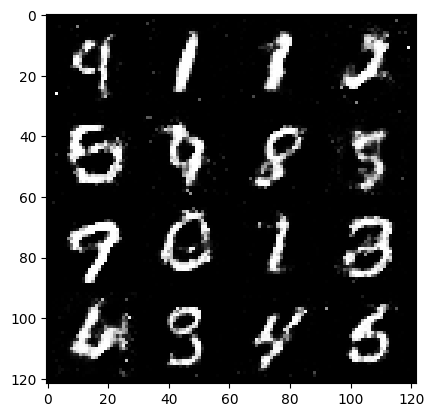

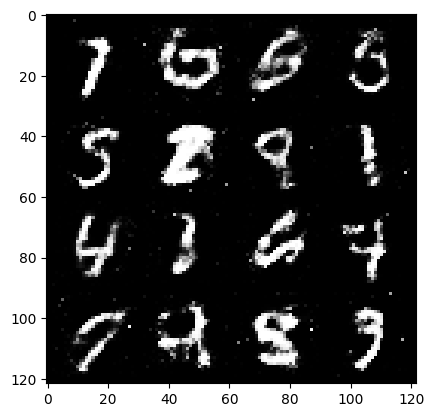

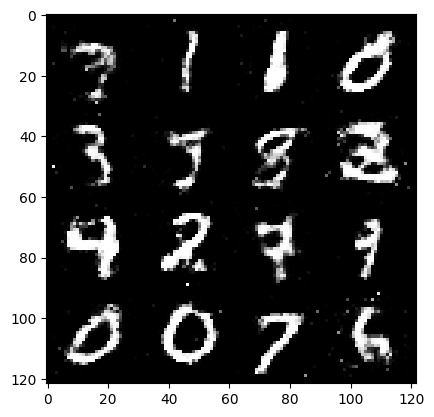

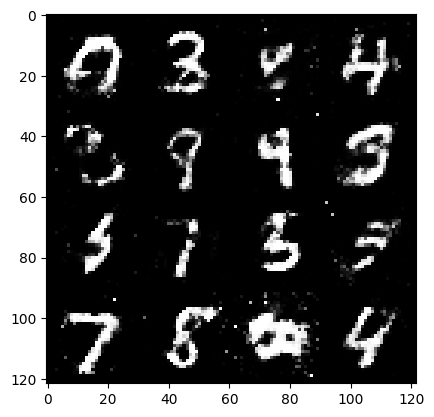

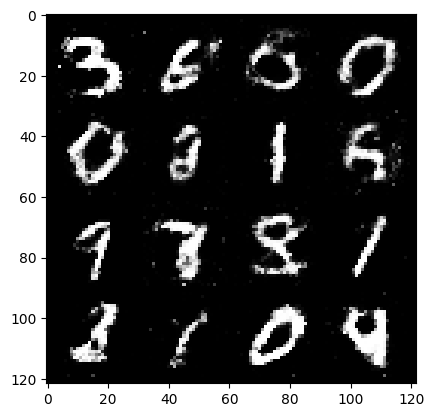

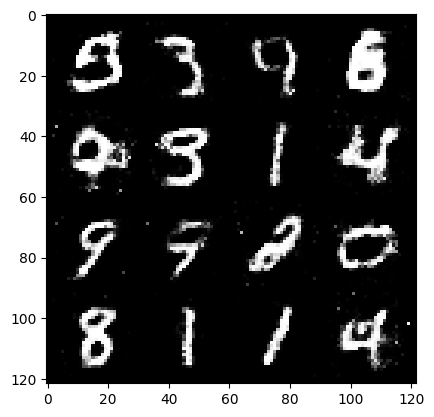

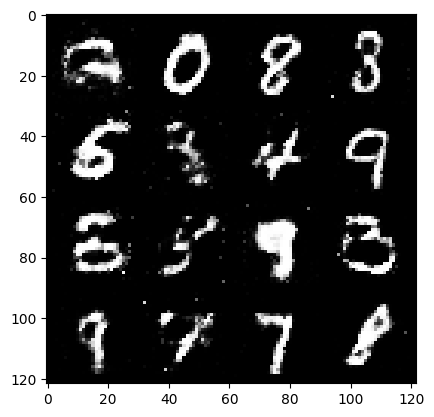

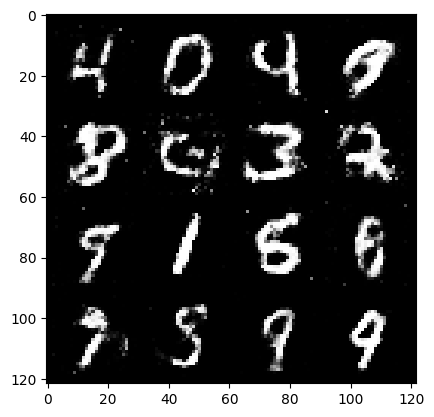

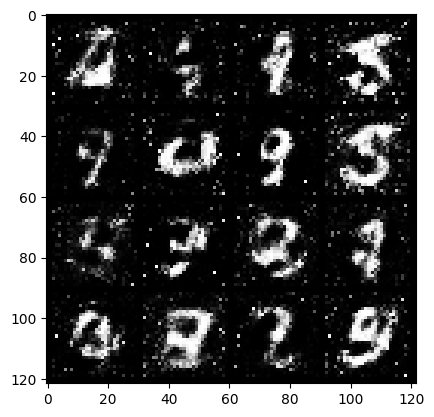

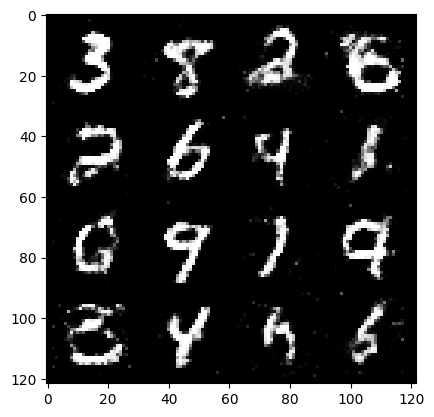

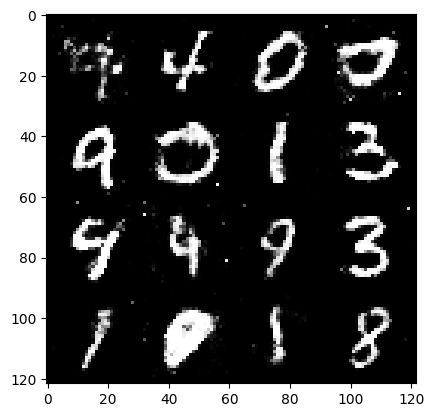

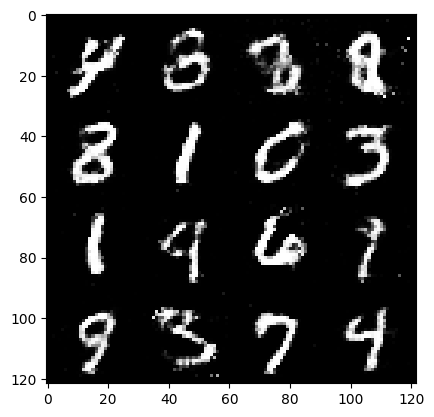

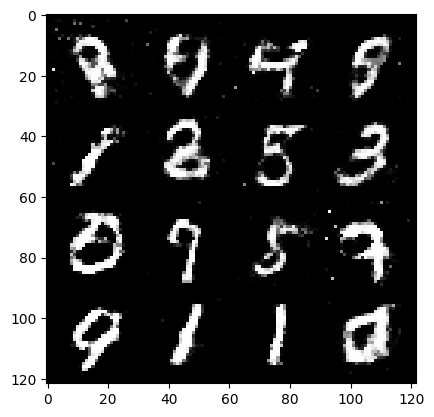

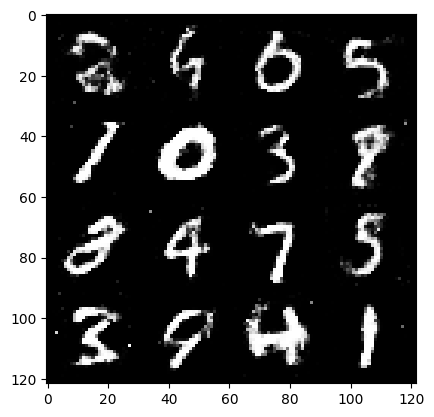

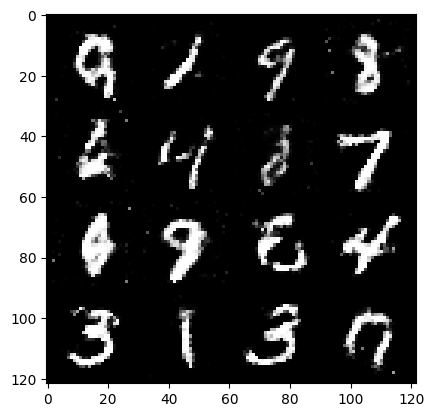

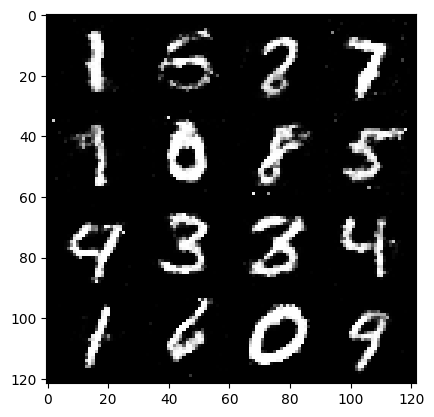

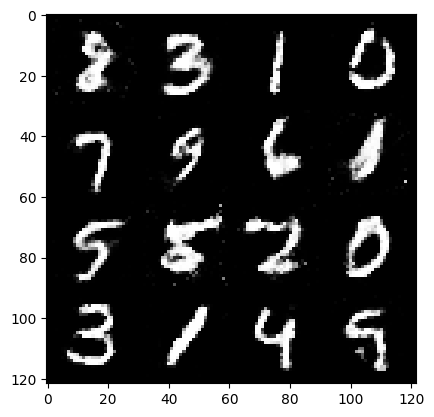

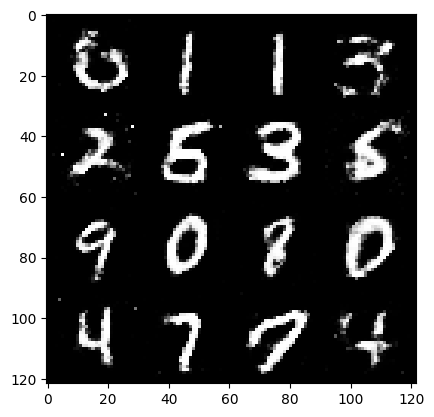

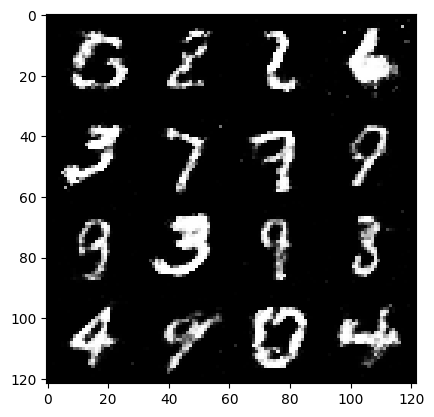

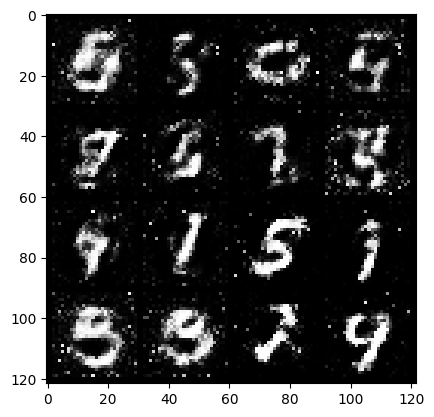

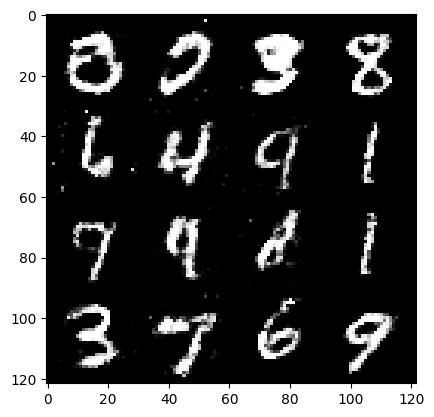

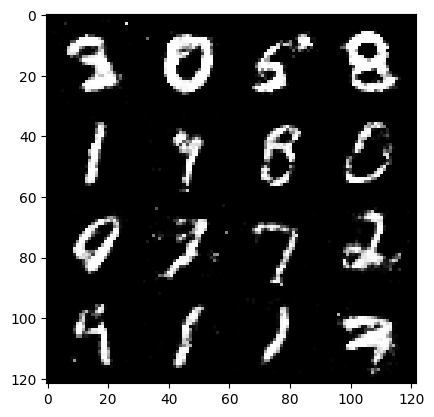

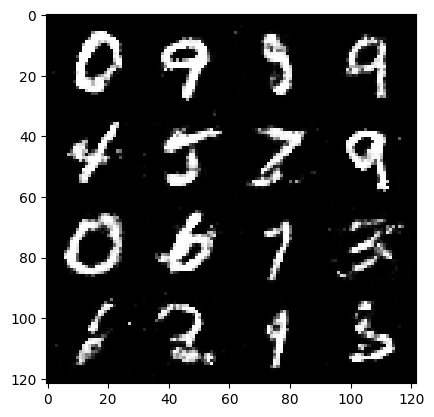

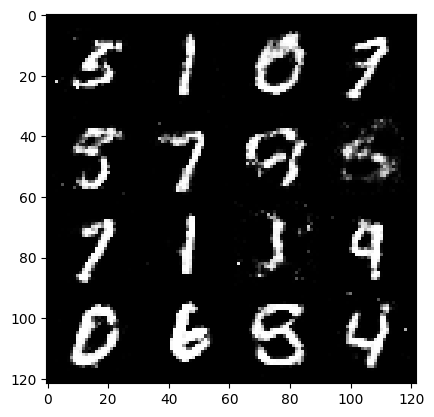

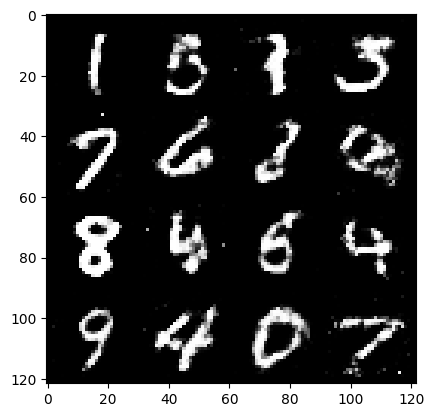

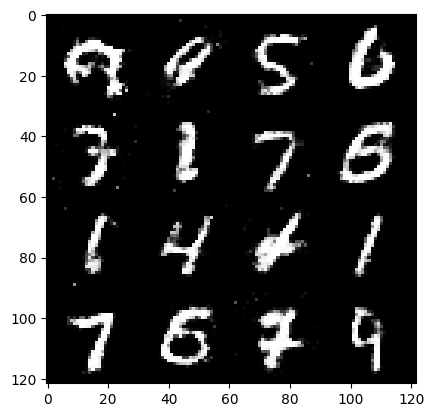

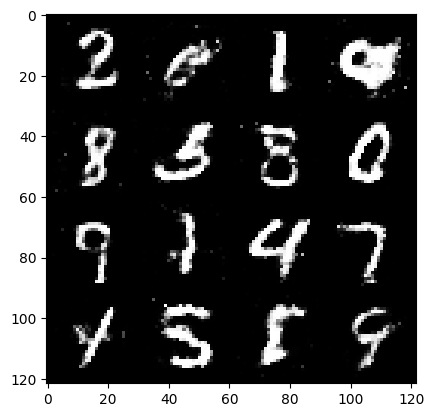

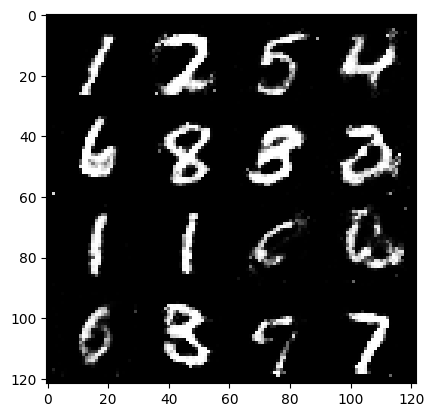

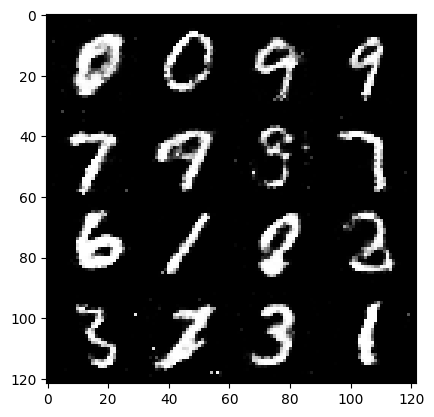

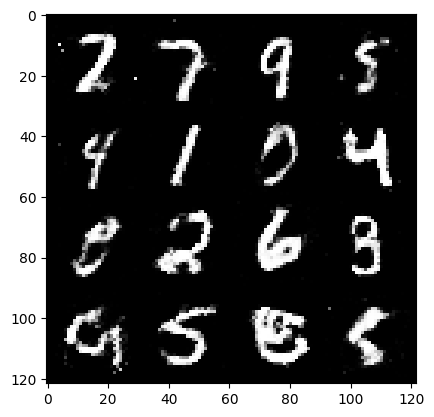

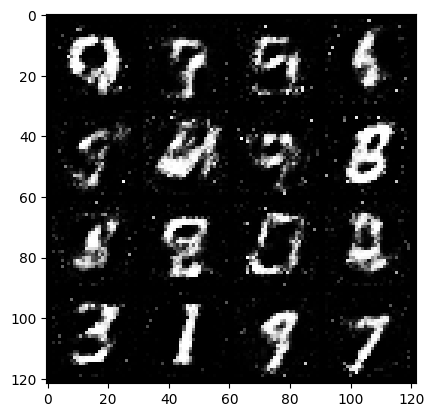

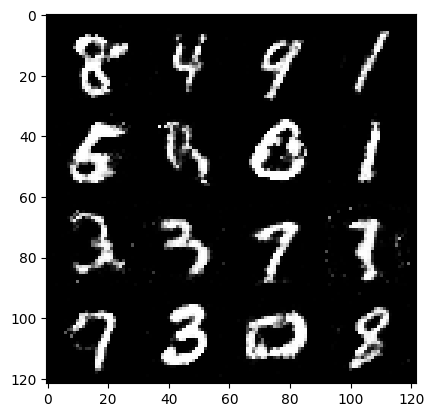

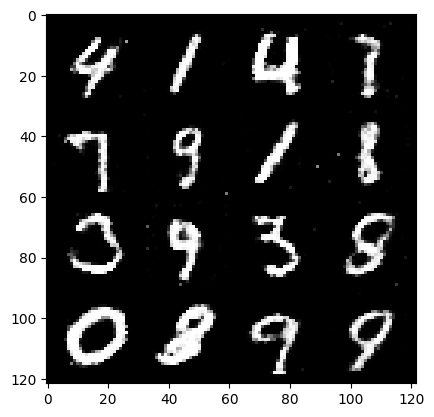

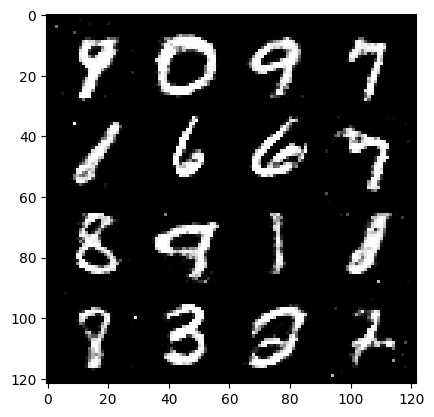

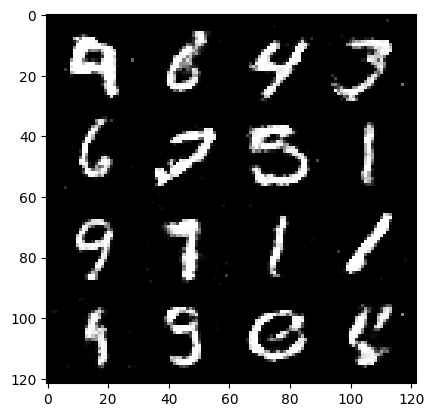

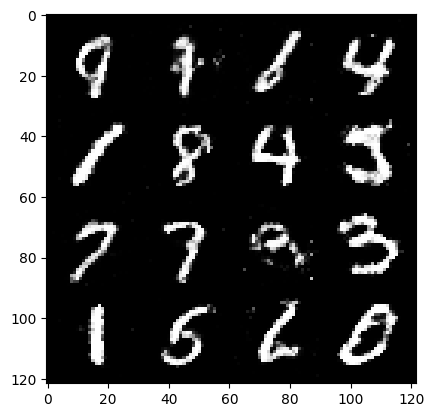

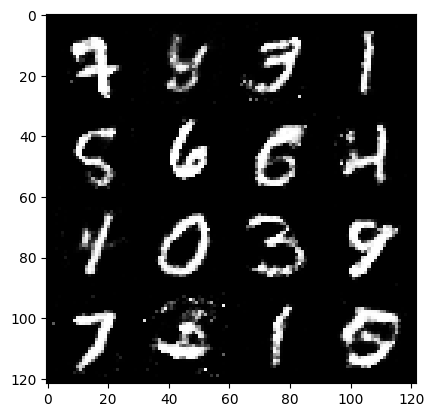

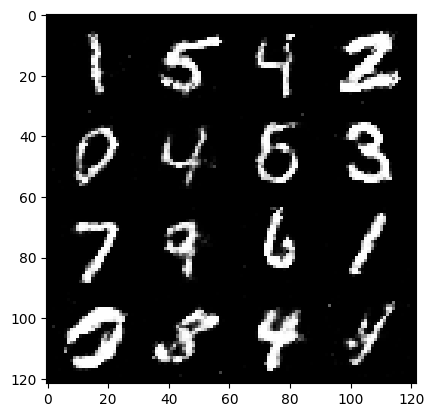

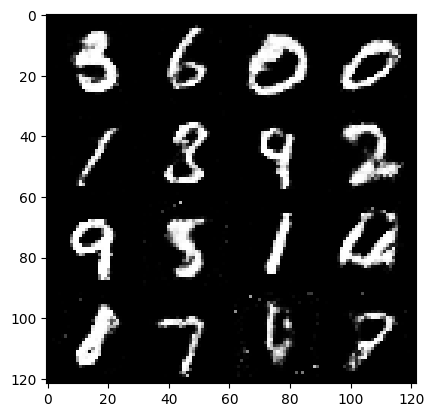

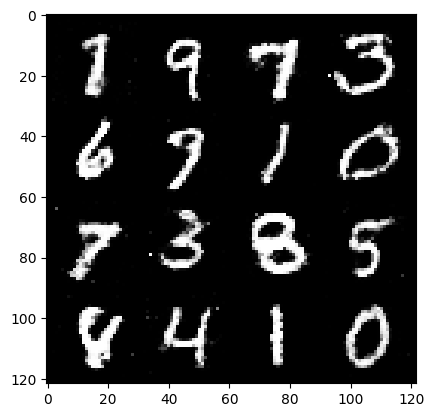

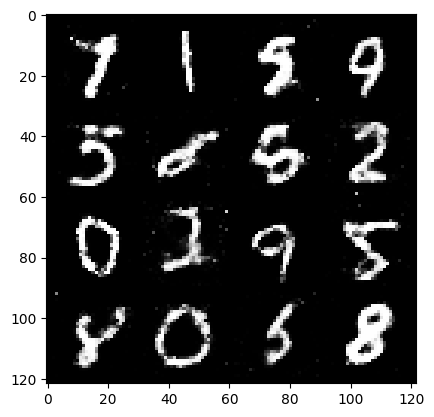

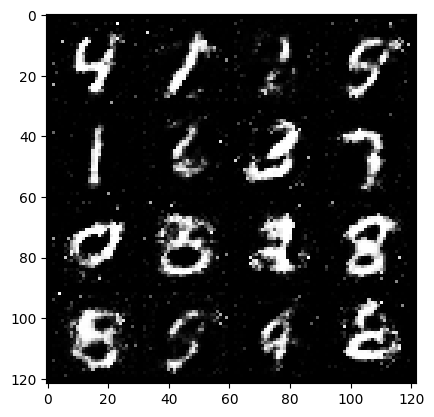

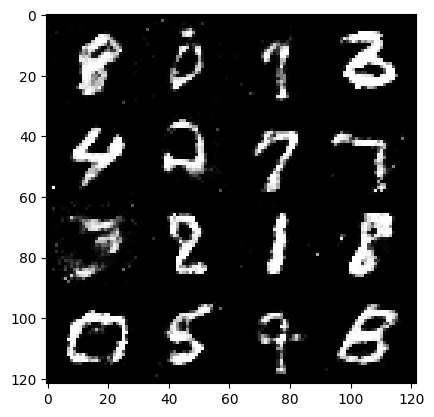

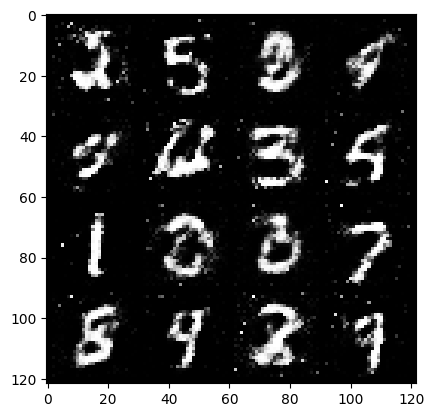

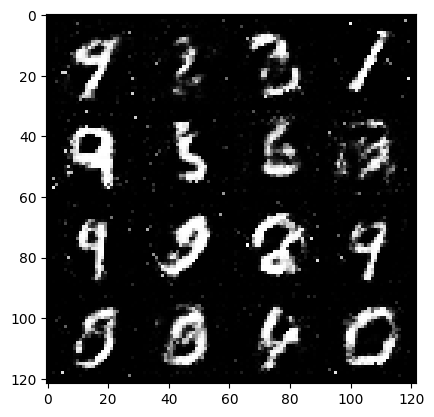

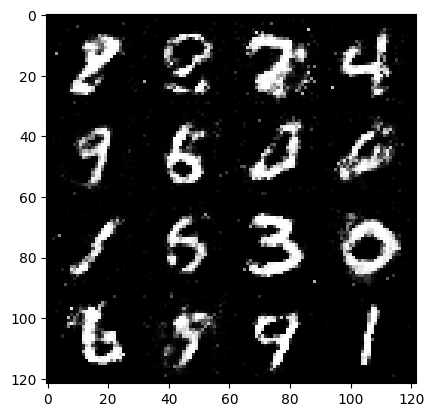

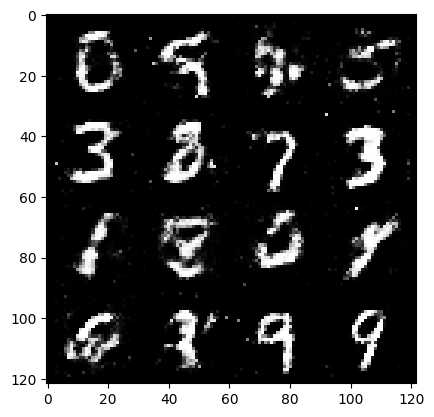

In [ ]:
for i in sorted(glob.glob('*.png')):
  plt.figure()
  plt.imshow(cv2.imread(i), cmap='gray')
